 In this notebook we create a model that predicts which passengers survived the Titanic shipwreck.

# 1. Import libraries

In [1]:
# Data wrangling
import pandas as pd
import numpy as np
from collections import Counter
# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
# Machine learning models
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
# Model evaluation
from sklearn.model_selection import cross_val_score
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Import and read data

We import and read the 3 datasets : Training set,Test set and Sample submission.
We'll be using the training set to build our predictive model and the testing set to score it and generate an output file to submit on the Kaggle evaluation system.

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
# import data
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')
sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [4]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

The Survived column is the target variable. If Suvival = 1 the passenger survived, otherwise he's dead. The is the variable we're going to predict.

In [5]:
print("Training set shape: ", train.shape)
print("Test set shape: ", test.shape)
print("Sample submission shape: ", sub.shape)

Training set shape:  (891, 12)
Test set shape:  (418, 11)
Sample submission shape:  (418, 2)


# 3. Exploratory Data Analysis (EDA)

In [6]:
# data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
# Missing data in training set 
train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

The 'Age', 'Cabin', 'Embarked' columns have missing values.

In [9]:
# Missing data in testing set 
test.isnull().sum().sort_values(ascending = False)

Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64

The 'Age', 'Cabin', 'Fare' columns have missing values.

Pandas allows you to a have a high-level simple statistical description of the numerical features. This can be done using the describe method.

In [10]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

that is 177 values are missing in the Age column.
One solution is to fill in the null values with the median age. We could also impute with the mean age but the median is more robust to outliers.

In [11]:
train.describe(include="O")

Name   Sex  Ticket    Cabin Embarked
count                       891   891     891      204      889
unique                      891     2     681      147        3
top     Braund, Mr. Owen Harris  male  347082  B96 B98        S
freq                          1   577       7        4      644

There are a lot of missing values in 'Cabin', maybe there is difference between the survival rate of people who has Cabin number and those who hasn't.

In [12]:
train.loc[train.Cabin.notnull(),'Cabin']=1
train.loc[train.Cabin.isnull(),'Cabin']=0

In [13]:
test.loc[test.Cabin.notnull(),'Cabin']=1
test.loc[test.Cabin.isnull(),'Cabin']=0

In [14]:
train.Cabin.isnull().sum()

0

In [15]:
test.Cabin.isnull().sum()

0

## 3.2 Feature analysis

In this section, we will analyse the features in our dataset individually and see how they correlate with survival probability.

### 3.2.1 Numerical variables
The numerical variables are : SibSp, Parch, Age, Pclass and Fare.

### Detect and drop the outliers

In [16]:
def detect_outliers(df, n, features):

    outlier_indices = [] 
    for col in features: 
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n) 
    return multiple_outliers

In [17]:
outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
print("The {} indices for the outliers to drop are: ".format(len(outliers_to_drop)), outliers_to_drop)

The 10 indices for the outliers to drop are:  [27, 88, 159, 180, 201, 324, 341, 792, 846, 863]


In [18]:
# Outliers in numerical variables
train.loc[outliers_to_drop, :]

PassengerId  Survived  Pclass                               Name     Sex  \
27            28         0       1     Fortune, Mr. Charles Alexander    male   
88            89         1       1         Fortune, Miss. Mabel Helen  female   
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
324          325         0       3           Sage, Mr. George John Jr    male   
341          342         1       1     Fortune, Miss. Alice Elizabeth  female   
792          793         0       3            Sage, Miss. Stella Anna  female   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

      Age  SibSp  Parch    Ticket    Fare Cabin Embarked  
27   19.0      3      2     19950  263.00     1        S  
88   23.0      3      2     19950  263.00     1        S  
159   NaN      8      2  CA. 2343   69.55     0        S  
180   NaN      8      2  CA. 2343   69.55     0        S  
201   NaN      8      2  CA. 2343   69.55     0        S  
324   NaN      8      2  CA. 2343   69.55     0        S  
341  24.0      3      2     19950  263.00     1        S  
792   NaN      8      2  CA. 2343   69.55     0        S  
846   NaN      8      2  CA. 2343   69.55     0        S  
863   NaN      8      2  CA. 2343   69.55     0        S

In [19]:
# Drop outliers and reset index
print("Before: {} rows".format(len(train)))
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop = True)
print("After: {} rows".format(len(train)))

Before: 891 rows
After: 881 rows


In [20]:
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292     0        Q  
1  47.0      1      0   363272   7.0000     0        S  
2  62.0      0      0   240276   9.6875     0        Q  
3  27.0      0      0   315154   8.6625     0        S  
4  22.0      1      1  3101298  12.2875     0        S

In [21]:
outliers_to_drop_to_test = detect_outliers(test, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [22]:
# Outliers in numerical variables
test.loc[outliers_to_drop_to_test, :]

Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []

### Numerical variables correlation with survival

<AxesSubplot:>

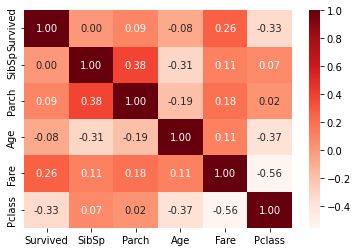

In [23]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare', 'Pclass']].corr(), annot = True, fmt = '.2f', cmap = 'Reds')

### Numerical variable: SibSp

In [24]:
# Value counts of the SibSp column 
train['SibSp'].value_counts(dropna = False)

0    608
1    209
2     28
4     18
3     13
5      5
Name: SibSp, dtype: int64

In [25]:
# Mean of survival by SibSp
train[['SibSp', 'Survived']].groupby('SibSp', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
4      4  0.166667
3      3  0.153846
5      5  0.000000

Text(0.5, 1.0, 'Survival Probability by SibSp')

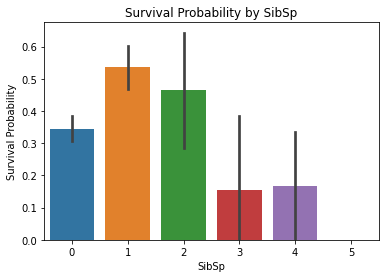

In [26]:
sns.barplot(x = 'SibSp', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by SibSp')

### Numerical variable: Parch

In [27]:
# Value counts of the Parch column 
train['Parch'].value_counts(dropna = False)

0    678
1    118
2     70
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [28]:
# Mean of survival by Parch
train[['Parch', 'Survived']].groupby('Parch', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.542857
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000

Text(0.5, 1.0, 'Survival Probability by Parch')

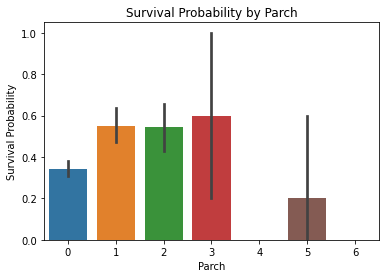

In [29]:
sns.barplot(x = 'Parch', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Parch')

### Numerical variable: Age

In [30]:
# Null values in Age column 
train['Age'].isnull().sum()

170

Text(0.5, 1.0, 'Passenger Age Distribution')

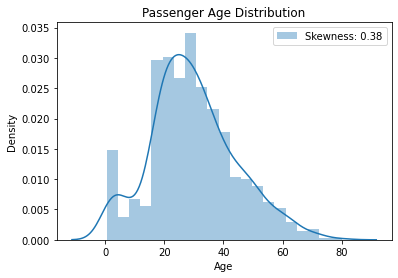

In [31]:
# Passenger age distribution
sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Age Distribution')

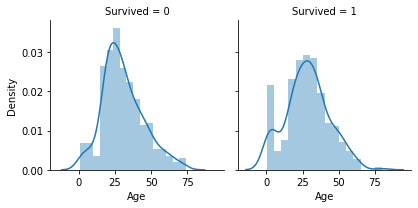

In [32]:
# Age distribution by survival
g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Age')

Text(0.5, 1.0, 'Passenger Age Distribution by Survival')

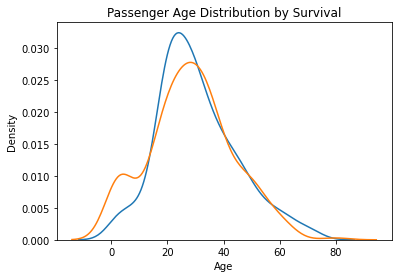

In [33]:
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Died')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')

### Numerical variable: Fare

In [34]:
# Null values of Fare column 
train['Fare'].isnull().sum()

0

Text(0, 0.5, 'Passenger Pclass Distribution')

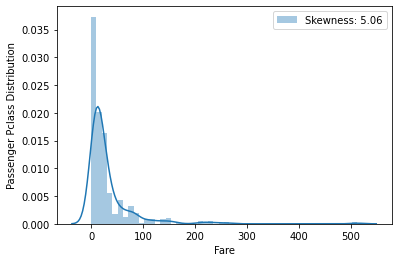

In [35]:
# Passenger fare distribution
sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Pclass Distribution')

### Numerical variable: Pclass

In [36]:
# Value counts of the SibSp column 

train['Pclass'].value_counts(dropna = False)

3    484
1    213
2    184
Name: Pclass, dtype: int64

In [37]:
# Mean of survival by class
train[['Pclass', 'Survived']].groupby('Pclass', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Pclass  Survived
0       1  0.629108
1       2  0.472826
2       3  0.245868

Text(0.5, 1.0, 'Survival Probability by Pclass')

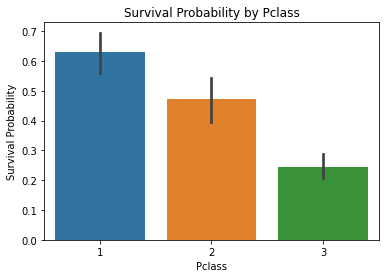

In [38]:
sns.barplot(x = 'Pclass', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Pclass')

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

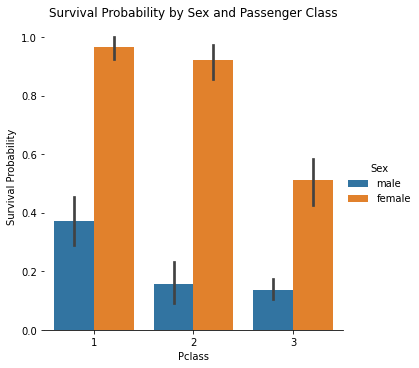

In [39]:
# Survival by gender and passenger class

g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')
g.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

Text(0, 0.5, 'Passenger Fare Distribution')

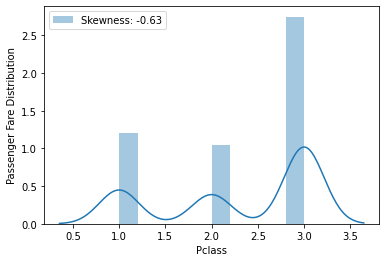

In [40]:
# Passenger fare distribution
sns.distplot(train['Pclass'], label = 'Skewness: %.2f'%(train['Pclass'].skew()))
plt.legend(loc = 'best')
plt.ylabel('Passenger Fare Distribution')

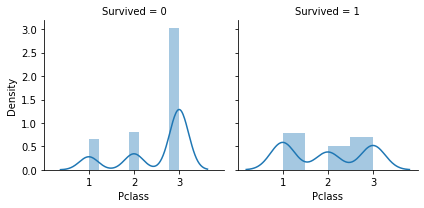

In [41]:
# Age distribution by survival
g = sns.FacetGrid(train, col = 'Survived')
g.map(sns.distplot, 'Pclass')

## 3.2.2 Categorical variables

### Categorical variable: Sex

In [42]:
# Value counts of the sex column
train['Sex'].value_counts(dropna = False)

male      572
female    309
Name: Sex, dtype: int64

In [43]:
# Mean of survival by sex
train[['Sex', 'Survived']].groupby('Sex', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Sex  Survived
0  female  0.747573
1    male  0.190559

Text(0.5, 1.0, 'Survival Probability by Gender')

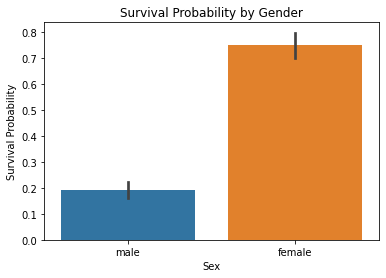

In [44]:
sns.barplot(x = 'Sex', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Gender')

### Categorical variable: Embarked

In [45]:
# Value counts of the Embarked column 
train['Embarked'].value_counts(dropna = False)

S      634
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [46]:
# Mean of survival by point of embarkation
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339117

Text(0.5, 1.0, 'Survival Probability by Point of Embarkation')

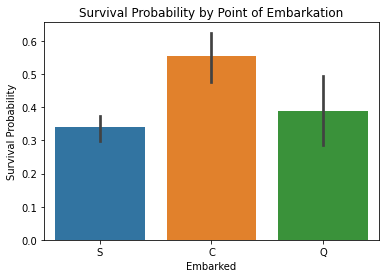

In [47]:
sns.barplot(x = 'Embarked', y ='Survived', data = train)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Point of Embarkation')

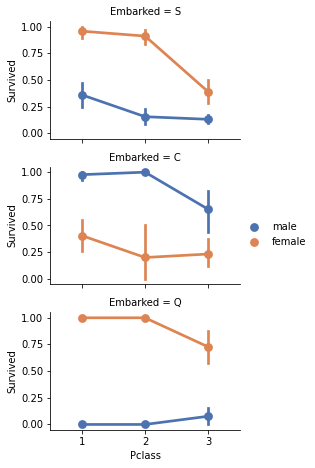

In [48]:
# Survival probability by all categorical variables
grid = sns.FacetGrid(train, row = 'Embarked', size = 2.2, aspect = 1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
grid.add_legend()

### Categorical variable: Cabin

Text(0.5, 1.0, 'Survival Rate')

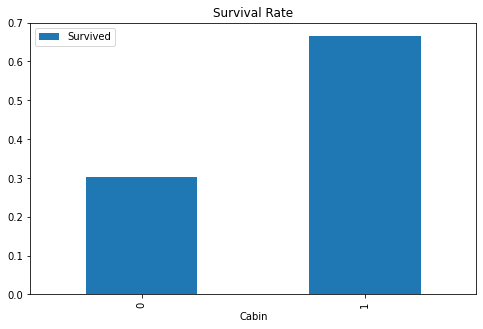

In [49]:
pd.pivot_table(train,index=['Cabin'],values=['Survived']).plot.bar(figsize=(8,5))
plt.title('Survival Rate')

In [50]:
cabin=pd.crosstab(train.Cabin,train.Survived)
cabin.rename(index={0:'no cabin',1:'cabin'},columns={0.0:'Died',1.0:'Survived'},inplace=True)
cabin

Survived  Died  Survived
Cabin                   
no cabin   474       206
cabin       67       134

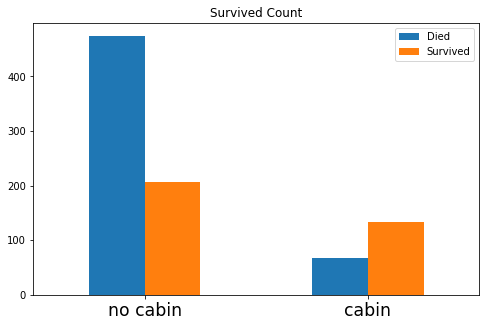

In [51]:
cabin.plot.bar(figsize=(8,5))
plt.xticks(rotation=0,size='xx-large')
plt.title('Survived Count')
plt.xlabel('')
plt.legend()

# 4. Data preprocessing

In this section, we will perform the following preprocessing steps:

Drop and fill missing values
Data trasformation (log transformation)
Feature engineering
Feature encoding

there are some variables that have nothing to do with the probability of survival like PassengerId, the ticket number, the cabin number (but not maybe if they have a cabin or not, to be checked ). So we can file them safely before building our ml model. In addition, we also have to manage the missing values. So, all these tasks are data preprocessing.

In [52]:
# Drop ticket  feature from training and test set
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

In [53]:
# Missing values in training set 
train.isnull().sum().sort_values(ascending = False)

Age            170
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Cabin            0
dtype: int64

In [54]:
# Compute the most frequent value of Embarked in training set
mode = train['Embarked'].dropna().mode()[0]
mode

'S'

In [55]:
# Fill missing value in Embarked with mode
train['Embarked'].fillna(mode, inplace = True)

In [56]:
# Missing values in test set
test.isnull().sum().sort_values(ascending = False)

Age            86
Fare            1
PassengerId     0
Pclass          0
Name            0
Sex             0
SibSp           0
Parch           0
Cabin           0
Embarked        0
dtype: int64

In [57]:
# Compute median of Fare in test set 
median = test['Fare'].dropna().median()
median

14.4542

In [58]:
# Fill missing value in Fare with median
test['Fare'].fillna(median, inplace = True)

In [59]:
# Combine training set and test set
combine = pd.concat([train, test], axis = 0).reset_index(drop = True)
combine.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch     Fare Cabin Embarked  
0      0   7.2500     0        S  
1      0  71.2833     1        C  
2      0   7.9250     0        S  
3      0  53.1000     1        S  
4      0   8.0500     0        S

In [60]:
# Missing values in the combined dataset
combine.isnull().sum().sort_values(ascending = False)

Survived       418
Age            256
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Fare             0
Cabin            0
Embarked         0
dtype: int64

The goal is to use features that are most correlated with Age to predict the values for Age. But first, we need to convert Sex into numerical values where 0 = male and 1 = female. This process is known as encoding and we will further explore this later in the notebook.

In [61]:
# Convert Sex into numerical values where 0 = male and 1 = female
combine['Sex'] = combine['Sex'].map({'male': 0, 'female': 1})

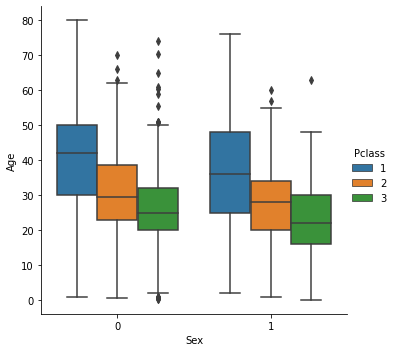

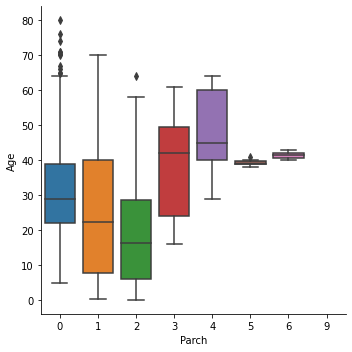

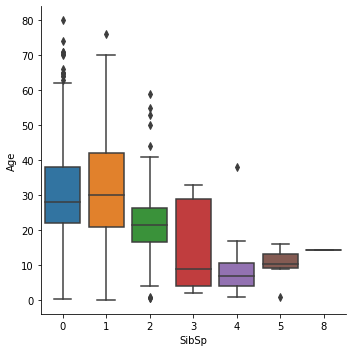

In [62]:
sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = combine)
sns.factorplot(y = 'Age', x = 'Parch', kind = 'box', data = combine)
sns.factorplot(y = 'Age', x = 'SibSp', kind = 'box', data = combine)

<AxesSubplot:>

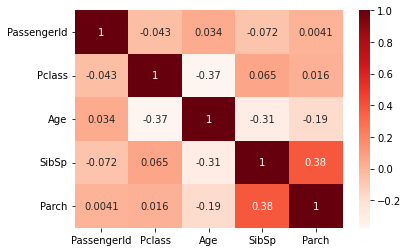

In [63]:
sns.heatmap(train.drop(['Survived', 'Name', 'Fare'], axis = 1).corr(), annot = True, cmap = 'Reds')

Age is not correlated with Sex but is negatively correlated with SibSp, Parch and Pclass.

In [64]:
# Check number of missing ages 
age_nan_indices = list(combine[combine['Age'].isnull()].index)
len(age_nan_indices)

256

Loop through each missing age in the list to locate the rows that have the same SibSp, Parch and PClass values and fill the missing age with the median of those rows. If rows are not found, simply fill the missing age with the median of the entire Age column.

In [65]:
# Loop through list and impute missing ages
for index in age_nan_indices:
    median_age = combine['Age'].median()
    predict_age = combine['Age'][(combine['SibSp'] == combine.iloc[index]['SibSp']) 
                                 & (combine['Parch'] == combine.iloc[index]['Parch'])
                                 & (combine['Pclass'] == combine.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combine['Age'].iloc[index] = median_age
    else:
        combine['Age'].iloc[index] = predict_age

In [66]:
# Make sure there is no more missing ages 
combine['Age'].isnull().sum()

0

## 4.2 Data transformation

Recall that our passenger fare column has a very high positive skewness. Therefore, we will apply a log transformation to address this issue.

Text(0.5, 1.0, 'Passenger Fare Distribution')

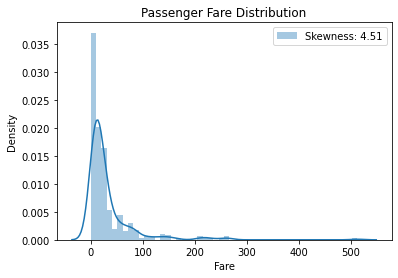

In [67]:
# Passenger fare distribution
sns.distplot(combine['Fare'], label = 'Skewness: %.2f'%(combine['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution')

In [68]:
# Apply log transformation to Fare column to reduce skewness
train['Fare'] = train['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Text(0.5, 1.0, 'Passenger Fare Distribution After Log Transformation')

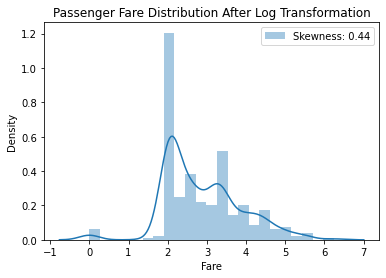

In [69]:
# Passenger fare distribution after log transformation
sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()))
plt.legend(loc = 'best')
plt.title('Passenger Fare Distribution After Log Transformation')

## 4.3 Feature engineering

In this section, I will construct 3 new features:

Title
Alone
Major

### 4.3.1 Title

In [70]:
combine.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

      Fare Cabin Embarked  
0   7.2500     0        S  
1  71.2833     1        C  
2   7.9250     0        S  
3  53.1000     1        S  
4   8.0500     0        S

In [71]:
# Get title from name
combine['Title'] = [name.split(',')[1].split('.')[0].strip() for name in combine['Name']]
combine[['Name', 'Title']].head()

Name Title
0                            Braund, Mr. Owen Harris    Mr
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   Mrs
2                             Heikkinen, Miss. Laina  Miss
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   Mrs
4                           Allen, Mr. William Henry    Mr

In [72]:
# Value counts of Title
combine['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [73]:
# Number of unique Title
combine['Title'].nunique()

18

In [74]:
# Simplify title
combine['Title'] = combine['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt'], 'Officer')
combine['Title'] = combine['Title'].replace(['Lady', 'Jonkheer', 'Don','the Countess','Sir', 'Dona'], 'Royalty')
combine['Title'] = combine['Title'].replace(['Mlle', 'Miss'], 'Miss')
combine['Title'] = combine['Title'].replace(['Mme','Mrs','Ms'], 'Mrs')
combine['Title'] = combine['Title'].replace('Mr', 'Mr')
combine['Title'] = combine['Title'].replace('Master', 'Master')

<AxesSubplot:xlabel='Title', ylabel='count'>

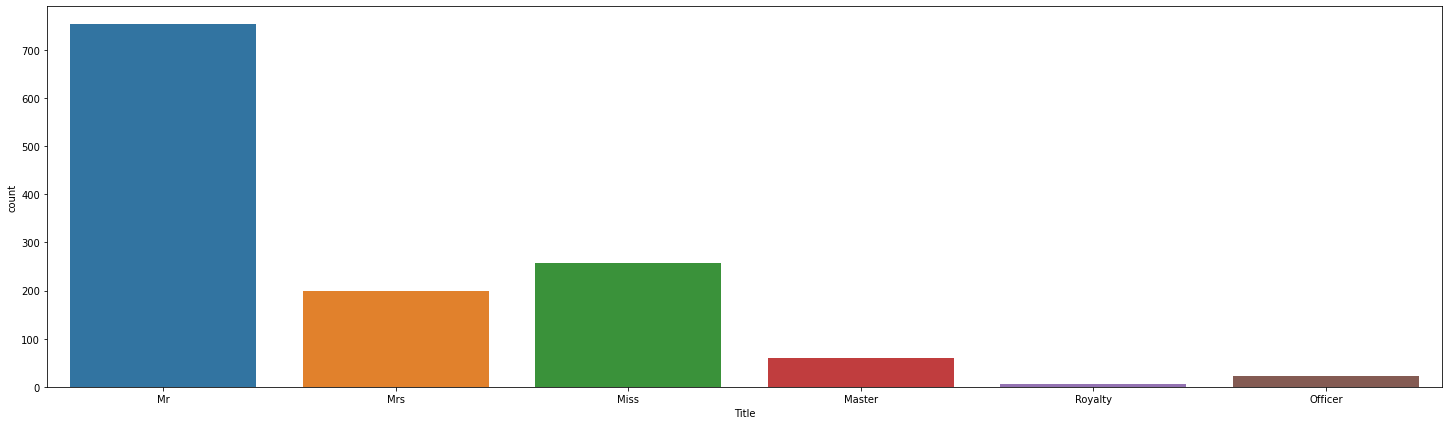

In [75]:
figure = plt.figure(figsize=(25, 7))
sns.countplot(combine['Title'])

In [76]:
# Mean of survival by name title
combine[['Title', 'Survived']].groupby(['Title'], as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Title  Survived
3      Mrs  0.795276
1     Miss  0.709497
5  Royalty  0.600000
0   Master  0.589744
4  Officer  0.277778
2       Mr  0.157895

Text(0.5, 1.0, 'Mean of survival by Title')

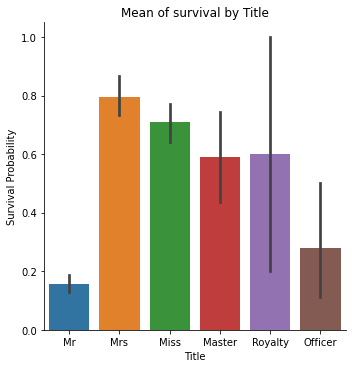

In [77]:
sns.factorplot(x = 'Title', y = 'Survived', data = combine, kind = 'bar')
plt.ylabel('Survival Probability')
plt.title('Mean of survival by Title')

In [78]:
# Drop name column
combine = combine.drop('Name', axis = 1)
combine.head()

PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare Cabin  \
0            1       0.0       3    0  22.0      1      0   7.2500     0   
1            2       1.0       1    1  38.0      1      0  71.2833     1   
2            3       1.0       3    1  26.0      0      0   7.9250     0   
3            4       1.0       1    1  35.0      1      0  53.1000     1   
4            5       0.0       3    0  35.0      0      0   8.0500     0   

  Embarked Title  
0        S    Mr  
1        C   Mrs  
2        S  Miss  
3        S   Mrs  
4        S    Mr

### 4.3.2 Alone

In [79]:
# Calculate family size from SibSp and Parch
combine['Family_Size'] = combine['SibSp'] + combine['Parch'] + 1
combine[['SibSp', 'Parch', 'Family_Size']].head(10)

SibSp  Parch  Family_Size
0      1      0            2
1      1      0            2
2      0      0            1
3      1      0            2
4      0      0            1
5      0      0            1
6      0      0            1
7      3      1            5
8      0      2            3
9      1      0            2

In [80]:
# Mean of survival by family_size
combine[['Family_Size', 'Survived']].groupby('Family_Size', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Family_Size  Survived
3            4  0.724138
2            3  0.578431
1            2  0.552795
6            7  0.333333
0            1  0.303538
4            5  0.200000
5            6  0.052632
7            8  0.000000
8           11       NaN

In [81]:
# Create Alone feature
combine['Alone'] = 0
combine.loc[combine['Family_Size'] == 1, 'Alone'] = 1

In [82]:
# Mean of survival by Alone
combine[['Alone', 'Survived']].groupby('Alone', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Alone  Survived
0      0  0.514535
1      1  0.303538

In [83]:
# Drop SibSp, Parch and FamilySize features from combine dataframe
combine = combine.drop(['SibSp', 'Parch', 'Family_Size'], axis = 1)
combine.head()

PassengerId  Survived  Pclass  Sex   Age     Fare Cabin Embarked Title  \
0            1       0.0       3    0  22.0   7.2500     0        S    Mr   
1            2       1.0       1    1  38.0  71.2833     1        C   Mrs   
2            3       1.0       3    1  26.0   7.9250     0        S  Miss   
3            4       1.0       1    1  35.0  53.1000     1        S   Mrs   
4            5       0.0       3    0  35.0   8.0500     0        S    Mr   

   Alone  
0      0  
1      0  
2      1  
3      0  
4      1

## 5.3.3 Major

To create  Major and Minor features,  to  transform Age 

In [84]:
combine['Minor'] = combine['Age'] <= 17
combine['Major'] = 1 - combine['Minor']  

In [85]:
combine[['Major', 'Survived']].groupby('Major', as_index = False).mean().sort_values(by = 'Survived', ascending = False)

Major  Survived
0      0  0.524590
1      1  0.363636

In [86]:
combine.loc[(combine['Age'] <= 17), 'Major'] = 0
combine.loc[(combine['Age'] > 17), 'Major'] = 1

In [87]:
combine.head()

PassengerId  Survived  Pclass  Sex   Age     Fare Cabin Embarked Title  \
0            1       0.0       3    0  22.0   7.2500     0        S    Mr   
1            2       1.0       1    1  38.0  71.2833     1        C   Mrs   
2            3       1.0       3    1  26.0   7.9250     0        S  Miss   
3            4       1.0       1    1  35.0  53.1000     1        S   Mrs   
4            5       0.0       3    0  35.0   8.0500     0        S    Mr   

   Alone  Minor  Major  
0      0  False      1  
1      0  False      1  
2      1  False      1  
3      0  False      1  
4      1  False      1

In [88]:
# Drop Age and Minor from combine dataframe
combine = combine.drop(['Age', 'Minor'], axis = 1)
combine.head()

PassengerId  Survived  Pclass  Sex     Fare Cabin Embarked Title  Alone  \
0            1       0.0       3    0   7.2500     0        S    Mr      0   
1            2       1.0       1    1  71.2833     1        C   Mrs      0   
2            3       1.0       3    1   7.9250     0        S  Miss      1   
3            4       1.0       1    1  53.1000     1        S   Mrs      0   
4            5       0.0       3    0   8.0500     0        S    Mr      1   

   Major  
0      1  
1      1  
2      1  
3      1  
4      1

## 4. Feature encoding

Previously, we have encoded the sex column such that 0 = male and 1 = female. We need to repeat this process for Title and Embarked.

In [89]:
combine.head()

PassengerId  Survived  Pclass  Sex     Fare Cabin Embarked Title  Alone  \
0            1       0.0       3    0   7.2500     0        S    Mr      0   
1            2       1.0       1    1  71.2833     1        C   Mrs      0   
2            3       1.0       3    1   7.9250     0        S  Miss      1   
3            4       1.0       1    1  53.1000     1        S   Mrs      0   
4            5       0.0       3    0   8.0500     0        S    Mr      1   

   Major  
0      1  
1      1  
2      1  
3      1  
4      1

In [90]:
# Encode Title and Embarked feature
combine = pd.get_dummies(combine, columns = ['Title'])
combine = pd.get_dummies(combine, columns = ['Embarked'], prefix = 'Em')
combine.head()

PassengerId  Survived  Pclass  Sex     Fare Cabin  Alone  Major  \
0            1       0.0       3    0   7.2500     0      0      1   
1            2       1.0       1    1  71.2833     1      0      1   
2            3       1.0       3    1   7.9250     0      1      1   
3            4       1.0       1    1  53.1000     1      0      1   
4            5       0.0       3    0   8.0500     0      1      1   

   Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Officer  \
0             0           0         1          0              0   
1             0           0         0          1              0   
2             0           1         0          0              0   
3             0           0         0          1              0   
4             0           0         1          0              0   

   Title_Royalty  Em_C  Em_Q  Em_S  
0              0     0     0     1  
1              0     1     0     0  
2              0     0     0     1  
3              0     0     0     1  
4              0     0     0     1

I will also transform Fare into an ordinal variable rather than a continuous variable.

In [91]:
# Divide Fare into four bands
combine['Fare_Band'] = pd.cut(combine['Fare'], 4)
combine[['Fare_Band', 'Survived']].groupby(['Fare_Band'], as_index=False).mean().sort_values(by = 'Fare_Band')

Fare_Band  Survived
0   (-0.512, 128.082]  0.371158
1  (128.082, 256.165]  0.724138
2  (256.165, 384.247]  0.666667
3  (384.247, 512.329]  1.000000

In [92]:
# Assign ordinal to each fare band
combine.loc[combine['Fare'] <= 1.56, 'Fare'] = 0
combine.loc[(combine['Fare'] > 1.56) & (combine['Fare'] <= 3.119), 'Fare'] = 1
combine.loc[(combine['Fare'] > 3.119) & (combine['Fare'] <= 4.679), 'Fare'] = 2
combine.loc[combine['Fare'] > 4.679, 'Fare'] = 3

In [93]:
# Convert Fare into integer
combine['Fare'] = combine['Fare'].astype('int')

In [94]:
# Drop FareBand feature
combine = combine.drop('Fare_Band', axis = 1)

In [95]:
combine.head()

PassengerId  Survived  Pclass  Sex  Fare Cabin  Alone  Major  Title_Master  \
0            1       0.0       3    0     3     0      0      1             0   
1            2       1.0       1    1     3     1      0      1             0   
2            3       1.0       3    1     3     0      1      1             0   
3            4       1.0       1    1     3     1      0      1             0   
4            5       0.0       3    0     3     0      1      1             0   

   Title_Miss  Title_Mr  Title_Mrs  Title_Officer  Title_Royalty  Em_C  Em_Q  \
0           0         1          0              0              0     0     0   
1           0         0          1              0              0     1     0   
2           1         0          0              0              0     0     0   
3           0         0          1              0              0     0     0   
4           0         1          0              0              0     0     0   

   Em_S  
0     1  
1     0  
2     1  
3     1  
4     1

In [96]:
# Separate training and test set from the combined dataframe
train = combine[:len(train)]
test = combine[len(train):]

In [97]:
# Drop passenger ID column from and training set

train = train.drop('PassengerId', axis = 1)
train.head()

Survived  Pclass  Sex  Fare Cabin  Alone  Major  Title_Master  Title_Miss  \
0       0.0       3    0     3     0      0      1             0           0   
1       1.0       1    1     3     1      0      1             0           0   
2       1.0       3    1     3     0      1      1             0           1   
3       1.0       1    1     3     1      0      1             0           0   
4       0.0       3    0     3     0      1      1             0           0   

   Title_Mr  Title_Mrs  Title_Officer  Title_Royalty  Em_C  Em_Q  Em_S  
0         1          0              0              0     0     0     1  
1         0          1              0              0     1     0     0  
2         0          0              0              0     0     0     1  
3         0          1              0              0     0     0     1  
4         1          0              0              0     0     0     1

In [98]:
# Convert survived back to integer in the training set
train['Survived'] = train['Survived'].astype('int')
train.head()

Survived  Pclass  Sex  Fare Cabin  Alone  Major  Title_Master  Title_Miss  \
0         0       3    0     3     0      0      1             0           0   
1         1       1    1     3     1      0      1             0           0   
2         1       3    1     3     0      1      1             0           1   
3         1       1    1     3     1      0      1             0           0   
4         0       3    0     3     0      1      1             0           0   

   Title_Mr  Title_Mrs  Title_Officer  Title_Royalty  Em_C  Em_Q  Em_S  
0         1          0              0              0     0     0     1  
1         0          1              0              0     1     0     0  
2         0          0              0              0     0     0     1  
3         0          1              0              0     0     0     1  
4         1          0              0              0     0     0     1

In [99]:
# Drop passenger survived column from test set
test = test.drop('Survived', axis = 1)
test.head()

PassengerId  Pclass  Sex  Fare Cabin  Alone  Major  Title_Master  \
881          892       3    0     3     0      1      1             0   
882          893       3    1     3     0      0      1             0   
883          894       2    0     3     0      1      1             0   
884          895       3    0     3     0      1      1             0   
885          896       3    1     3     0      0      1             0   

     Title_Miss  Title_Mr  Title_Mrs  Title_Officer  Title_Royalty  Em_C  \
881           0         1          0              0              0     0   
882           0         0          1              0              0     0   
883           0         1          0              0              0     0   
884           0         1          0              0              0     0   
885           0         0          1              0              0     0   

     Em_Q  Em_S  
881     1     0  
882     0     1  
883     1     0  
884     0     1  
885     0     1

In [100]:
train['Cabin'] = train['Cabin'].astype('int')

In [101]:
test['Cabin'] = test['Cabin'].astype('int')

In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Survived       881 non-null    int64
 1   Pclass         881 non-null    int64
 2   Sex            881 non-null    int64
 3   Fare           881 non-null    int64
 4   Cabin          881 non-null    int64
 5   Alone          881 non-null    int64
 6   Major          881 non-null    int64
 7   Title_Master   881 non-null    uint8
 8   Title_Miss     881 non-null    uint8
 9   Title_Mr       881 non-null    uint8
 10  Title_Mrs      881 non-null    uint8
 11  Title_Officer  881 non-null    uint8
 12  Title_Royalty  881 non-null    uint8
 13  Em_C           881 non-null    uint8
 14  Em_Q           881 non-null    uint8
 15  Em_S           881 non-null    uint8
dtypes: int64(7), uint8(9)
memory usage: 56.0 KB


In [103]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 881 to 1298
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   PassengerId    418 non-null    int64
 1   Pclass         418 non-null    int64
 2   Sex            418 non-null    int64
 3   Fare           418 non-null    int64
 4   Cabin          418 non-null    int64
 5   Alone          418 non-null    int64
 6   Major          418 non-null    int64
 7   Title_Master   418 non-null    uint8
 8   Title_Miss     418 non-null    uint8
 9   Title_Mr       418 non-null    uint8
 10  Title_Mrs      418 non-null    uint8
 11  Title_Officer  418 non-null    uint8
 12  Title_Royalty  418 non-null    uint8
 13  Em_C           418 non-null    uint8
 14  Em_Q           418 non-null    uint8
 15  Em_S           418 non-null    uint8
dtypes: int64(7), uint8(9)
memory usage: 26.7 KB


# 5. Modelling

## 5.1 Split training data

In [104]:
X_train = train.drop('Survived', axis = 1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis = 1).copy()
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (881, 15)
Y_train shape:  (881,)
X_test shape:  (418, 15)


## 5.2 Fit model to data and make predictions

### 5.2.1 Logistic regression

In [105]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.7

### 5.2.2 Support vector machines

In [106]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

80.82

### 5.2.3 K-nearest neighbours (KNN)

In [107]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

83.09

### 5.2.4 Gaussian naive bayes

In [108]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.23

### 5.2.5 Perceptron

In [109]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

76.5

### 5.2.6 Linear SVC

In [110]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

80.02

### 5.2.7 Stochastic gradient descent 

In [111]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

76.28

### 5.2.8 Decision tree

In [112]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

84.11

### 5.2.9 Random forest

In [113]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

84.11

### 5.2.10 CatBoost

In [114]:
catboost = CatBoostClassifier(logging_level='Silent')
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

### 6.3 Model evaluation and hyperparameter tuning

### 6.3.1 Training accuracy

In [115]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

Model  Score
0               Random Forest  84.11
1               Decision Tree  84.11
2                    CatBoost  84.00
3                         KNN  83.09
4     Support Vector Machines  80.82
5         Logistic Regression  80.70
6                  Linear SVC  80.02
7                 Naive Bayes  79.23
8                  Perceptron  76.50
9  Stochastic Gradient Decent  76.28

### 6.3.2 K-fold cross validation

In [116]:
# Create a list which contains classifiers 

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [117]:
# Create a list which contains cross validation results for each classifier
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.009326
0:	learn: 0.6881161	total: 1.11ms	remaining: 1.11s
1:	learn: 0.6822615	total: 2.67ms	remaining: 1.33s
2:	learn: 0.6761136	total: 3.96ms	remaining: 1.31s
3:	learn: 0.6708782	total: 5.25ms	remaining: 1.31s
4:	learn: 0.6652169	total: 6.55ms	remaining: 1.3s
5:	learn: 0.6601454	total: 7.82ms	remaining: 1.3s
6:	learn: 0.6545933	total: 9.09ms	remaining: 1.29s
7:	learn: 0.6497000	total: 10.4ms	remaining: 1.29s
8:	learn: 0.6453183	total: 11.4ms	remaining: 1.26s
9:	learn: 0.6404439	total: 12.3ms	remaining: 1.21s
10:	learn: 0.6352625	total: 13.2ms	remaining: 1.18s
11:	learn: 0.6311086	total: 14.5ms	remaining: 1.19s
12:	learn: 0.6260087	total: 16ms	remaining: 1.22s
13:	learn: 0.6210266	total: 17.2ms	remaining: 1.21s
14:	learn: 0.6164819	total: 18.3ms	remaining: 1.2s
15:	learn: 0.6122492	total: 19.1ms	remaining: 1.17s
16:	learn: 0.6081450	total: 20.3ms	remaining: 1.17s
17:	learn: 0.6047079	total: 20.9ms	remaining: 1.14s
18:	learn: 0.6008270	total: 21.8ms	remaining: 1.1

In [118]:
# Mean and standard deviation of cross validation results for each classifier  
cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [119]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

Cross Validation Mean  Cross Validation Std                    Algorithm
0               0.822919              0.037453                     CatBoost
1               0.813828              0.035006                Decision Tree
2               0.813815              0.042999                          KNN
3               0.812679              0.042717                Random Forest
4               0.809270              0.040097          Logistic Regression
5               0.795710              0.041152      Support Vector Machines
6               0.788892              0.039335                   Linear SVC
7               0.763892              0.033711  Stochastic Gradient Descent
8               0.752541              0.122918          Gausian Naive Bayes
9               0.747983              0.054573                   Perceptron

Text(0.5, 1.0, 'Cross Validation Scores')

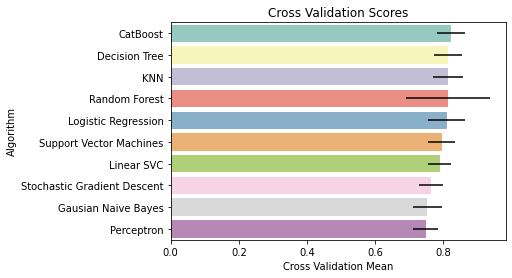

In [120]:
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores')

As we can see, CatBoost has the highest cross validation mean and thus we will proceed with this model.

### 6.3.3 Hyperparameter tuning for CatBoost

Hyperparameter tuning is the process of tuning the parameters of a model. Here I will tune the parameters of CatBost classifier using GridSearchCV.

In [121]:
# Create the parameter grid based on the results of random search 
param_grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}


# Instantiate the grid search model
grid = GridSearchCV(CatBoostClassifier(), param_grid = param_grid, 
                          cv = 3, refit=True, verbose = True)
grid.fit(X_train, Y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
0:	learn: 0.6752188	total: 724us	remaining: 724ms
1:	learn: 0.6553798	total: 1.53ms	remaining: 762ms
2:	learn: 0.6383711	total: 2.19ms	remaining: 729ms
3:	learn: 0.6215748	total: 2.85ms	remaining: 709ms
4:	learn: 0.6063875	total: 3.48ms	remaining: 693ms
5:	learn: 0.5926738	total: 4.25ms	remaining: 705ms
6:	learn: 0.5814792	total: 4.78ms	remaining: 678ms
7:	learn: 0.5693761	total: 5.5ms	remaining: 682ms
8:	learn: 0.5590827	total: 6.15ms	remaining: 678ms
9:	learn: 0.5482739	total: 6.95ms	remaining: 688ms
10:	learn: 0.5366742	total: 7.66ms	remaining: 689ms
11:	learn: 0.5276615	total: 8.36ms	remaining: 688ms
12:	learn: 0.5187330	total: 9.03ms	remaining: 686ms
13:	learn: 0.5103922	total: 9.63ms	remaining: 678ms
14:	learn: 0.5017695	total: 10.3ms	remaining: 677ms
15:	learn: 0.4959694	total: 10.9ms	remaining: 671ms
16:	learn: 0.4892865	total: 11.7ms	remaining: 674ms
17:	learn: 0.4835140	total: 13.1ms	remaining: 712ms
18:	learn: 0.47

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


179:	learn: 0.3622726	total: 114ms	remaining: 520ms
180:	learn: 0.3622586	total: 115ms	remaining: 520ms
181:	learn: 0.3620404	total: 115ms	remaining: 519ms
182:	learn: 0.3619315	total: 116ms	remaining: 518ms
183:	learn: 0.3618486	total: 117ms	remaining: 518ms
184:	learn: 0.3617586	total: 118ms	remaining: 521ms
185:	learn: 0.3615791	total: 120ms	remaining: 523ms
186:	learn: 0.3614076	total: 120ms	remaining: 524ms
187:	learn: 0.3613109	total: 121ms	remaining: 524ms
188:	learn: 0.3612228	total: 122ms	remaining: 524ms
189:	learn: 0.3611219	total: 123ms	remaining: 524ms
190:	learn: 0.3611106	total: 124ms	remaining: 523ms
191:	learn: 0.3609223	total: 124ms	remaining: 523ms
192:	learn: 0.3608779	total: 125ms	remaining: 522ms
193:	learn: 0.3608425	total: 126ms	remaining: 522ms
194:	learn: 0.3605699	total: 126ms	remaining: 521ms
195:	learn: 0.3605199	total: 127ms	remaining: 521ms
196:	learn: 0.3604970	total: 128ms	remaining: 520ms
197:	learn: 0.3601277	total: 128ms	remaining: 520ms
198:	learn: 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  5.1min finished


0:	learn: 0.6425963	total: 897us	remaining: 897ms
1:	learn: 0.5945065	total: 2.56ms	remaining: 1.27s
2:	learn: 0.5542782	total: 4.69ms	remaining: 1.56s
3:	learn: 0.5215889	total: 14.7ms	remaining: 3.66s
4:	learn: 0.4992394	total: 16.1ms	remaining: 3.21s
5:	learn: 0.4890700	total: 16.7ms	remaining: 2.77s
6:	learn: 0.4731366	total: 18.5ms	remaining: 2.63s
7:	learn: 0.4602672	total: 19.8ms	remaining: 2.46s
8:	learn: 0.4519743	total: 20.8ms	remaining: 2.29s
9:	learn: 0.4452378	total: 21.6ms	remaining: 2.14s
10:	learn: 0.4388392	total: 22.9ms	remaining: 2.06s
11:	learn: 0.4315458	total: 28.1ms	remaining: 2.32s
12:	learn: 0.4242224	total: 33.8ms	remaining: 2.56s
13:	learn: 0.4220821	total: 34.5ms	remaining: 2.43s
14:	learn: 0.4206995	total: 35.1ms	remaining: 2.3s
15:	learn: 0.4183384	total: 35.9ms	remaining: 2.21s
16:	learn: 0.4159298	total: 37.2ms	remaining: 2.15s
17:	learn: 0.4136915	total: 38ms	remaining: 2.07s
18:	learn: 0.4115518	total: 39.4ms	remaining: 2.03s
19:	learn: 0.4113505	total

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fb67ca5f590>,
             param_grid={'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.03, 0.1]},
             verbose=True)

In [122]:
print("Best parameters: ", grid.best_params_) 
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'depth': 10, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Best estimator:  <catboost.core.CatBoostClassifier object at 0x7fb686219450>


In [123]:
catboost = CatBoostClassifier(depth=10, l2_leaf_reg=5, learning_rate=0.1)
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

0:	learn: 0.6425963	total: 858us	remaining: 858ms
1:	learn: 0.5945065	total: 2.56ms	remaining: 1.28s
2:	learn: 0.5542782	total: 4.3ms	remaining: 1.43s
3:	learn: 0.5215889	total: 13.3ms	remaining: 3.32s
4:	learn: 0.4992394	total: 14.7ms	remaining: 2.94s
5:	learn: 0.4890700	total: 15.3ms	remaining: 2.53s
6:	learn: 0.4731366	total: 16.9ms	remaining: 2.4s
7:	learn: 0.4602672	total: 18ms	remaining: 2.23s
8:	learn: 0.4519743	total: 18.6ms	remaining: 2.05s
9:	learn: 0.4452378	total: 19.2ms	remaining: 1.9s
10:	learn: 0.4388392	total: 20.3ms	remaining: 1.82s
11:	learn: 0.4315458	total: 25.3ms	remaining: 2.08s
12:	learn: 0.4242224	total: 30.5ms	remaining: 2.32s
13:	learn: 0.4220821	total: 31.5ms	remaining: 2.22s
14:	learn: 0.4206995	total: 32.2ms	remaining: 2.12s
15:	learn: 0.4183384	total: 33.2ms	remaining: 2.04s
16:	learn: 0.4159298	total: 34.5ms	remaining: 2s
17:	learn: 0.4136915	total: 35.2ms	remaining: 1.92s
18:	learn: 0.4115518	total: 36.4ms	remaining: 1.88s
19:	learn: 0.4113505	total: 37m

In [124]:
# Mean cross validation score
cross_val_score(catboost, X_train, Y_train, scoring = 'accuracy', cv = 10).mean()

0:	learn: 0.6427345	total: 844us	remaining: 844ms
1:	learn: 0.5951930	total: 4.69ms	remaining: 2.34s
2:	learn: 0.5543613	total: 6.45ms	remaining: 2.14s
3:	learn: 0.5261426	total: 7.38ms	remaining: 1.84s
4:	learn: 0.5068030	total: 8.04ms	remaining: 1.6s
5:	learn: 0.4856503	total: 12.8ms	remaining: 2.13s
6:	learn: 0.4704396	total: 13.6ms	remaining: 1.93s
7:	learn: 0.4580268	total: 15ms	remaining: 1.86s
8:	learn: 0.4461117	total: 16.9ms	remaining: 1.86s
9:	learn: 0.4387683	total: 18.1ms	remaining: 1.79s
10:	learn: 0.4328564	total: 19.4ms	remaining: 1.74s
11:	learn: 0.4295204	total: 20.1ms	remaining: 1.65s
12:	learn: 0.4261144	total: 21.2ms	remaining: 1.61s
13:	learn: 0.4212992	total: 22.9ms	remaining: 1.61s
14:	learn: 0.4180239	total: 23.8ms	remaining: 1.56s
15:	learn: 0.4160010	total: 25.1ms	remaining: 1.54s
16:	learn: 0.4145267	total: 25.9ms	remaining: 1.5s
17:	learn: 0.4108898	total: 27.6ms	remaining: 1.51s
18:	learn: 0.4071120	total: 33.4ms	remaining: 1.73s
19:	learn: 0.4055360	total:

0.8217951991828396

In [125]:
# Survival predictions by CatBoost classifier
Y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [126]:
len(Y_pred)

418

# 7. Preparing data for submission

In [127]:
# Create submission dataframe
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})

In [128]:
# Create and save csv file 
output.to_csv("submission_titanic.csv", index = False)

In [129]:
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Conclusion


I achieved a submission score of 0.7799. In other words, I have correctly predicted 77.99 of the test set. 
I drew inspirations from the following notebooks in the making of this notebook:
* https://www.kaggle.com/startupsci/titanic-data-science-solutions Titanic Data Science Solutions by Manav Sehgal
* https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling Titanic Top 4% With Emsemble Modelling by Yassin Ghouzam
* https://www.kaggle.com/catadanna/titanic Titanesque by Catadanna